<a href="https://colab.research.google.com/github/vivekpatel99/Machine-Learning-with-Python-Zero-to-GBMs-by-Jovian/blob/master/Lesson_5_Gradient_Boosting_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Boosting Machines (GBMs) with XGBoost

This tutorial is a part of [Machine Learning with Python: Zero to GBMs](https://zerotogbms.com) and [Zero to Data Science Bootcamp by Jovian](https://zerotodatascience.com)

![](https://i.imgur.com/6MYc56a.png)

The following topics are covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Let's begin by installing the required libraries.

In [1]:
#restart the kernel after installation
!pip install numpy pandas-profiling matplotlib seaborn opendatasets --quiet

In [2]:
!pip install xgboost graphviz scikit-learn xgboost lightgbm --upgrade --quiet

     |████████████████████████████████| 255.9 MB 34 kB/s 
     |████████████████████████████████| 47 kB 4.7 MB/s 
     |████████████████████████████████| 2.0 MB 40.9 MB/s 


## Problem Statement

This tutorial takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

## Downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to [accept the competition rules](https://www.kaggle.com/c/rossmann-store-sales/rules) before executing the following cell.

In [3]:
import os
import opendatasets as od
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [4]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vivekpatel99
Your Kaggle Key: ··········


100%|██████████| 6.99M/6.99M [00:00<00:00, 115MB/s]


Extracting archive ./rossmann-store-sales/rossmann-store-sales.zip to ./rossmann-store-sales


In [5]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'store.csv', 'train.csv', 'test.csv']

In [6]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [7]:
ross_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [8]:
test_df.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

In [9]:
submission_df.head()

Id  Sales
0   1      0
1   2      0
2   3      0
3   4      0
4   5      0

In [10]:
store_df.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

> **EXERCISE**: Read the data description provided on the competition page to understand what the values in each column of `store_df` represent.

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]**- gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week] **- describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Let's merge the information from `store_df` into `train_df` and `test_df`.

In [11]:
store_df.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [12]:
ross_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [13]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [14]:
merged_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

In [15]:
merged_test_df.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday  \
0   1      1          4  2015-09-17   1.0      1            0              0   
1   2      3          4  2015-09-17   1.0      1            0              0   
2   3      7          4  2015-09-17   1.0      1            0              0   
3   4      8          4  2015-09-17   1.0      1            0              0   
4   5      9          4  2015-09-17   1.0      1            0              0   

  StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0         c          a               1270.0                        9.0   
1         a          a              14130.0                       12.0   
2         a          c              24000.0                        4.0   
3         a          a               7520.0                       10.0   
4         a          c               2030.0                        8.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2006.0       1             14.0           2011.0   
2                    2013.0       0              NaN              NaN   
3                    2014.0       0              NaN              NaN   
4                    2000.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2              NaN  
3              NaN  
4              NaN

> **EXERCISE**: Perform exploratory data analysis and visualization on the dataset. Study the distribution of values in each column, and their relationship with the target column `Sales`.

## Exploratory Data Analysis

In [81]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        842206 non-null  float64

In [82]:
merged_df.describe()

Store      DayOfWeek          Sales      Customers      Open  \
count  844392.000000  844392.000000  844392.000000  844392.000000  844392.0   
mean      558.422920       3.520361    6955.514291     762.728395       1.0   
std       321.731914       1.723689    3104.214680     401.227674       0.0   
min         1.000000       1.000000       0.000000       0.000000       1.0   
25%       280.000000       2.000000    4859.000000     519.000000       1.0   
50%       558.000000       3.000000    6369.000000     676.000000       1.0   
75%       837.000000       5.000000    8360.000000     893.000000       1.0   
max      1115.000000       7.000000   41551.000000    7388.000000       1.0   

               Promo  SchoolHoliday  CompetitionDistance  \
count  844392.000000  844392.000000        842206.000000   
mean        0.446352       0.193580          5457.979627   
std         0.497114       0.395103          7809.437311   
min         0.000000       0.000000            20.000000   
25%         0.000000       0.000000           710.000000   
50%         0.000000       0.000000          2320.000000   
75%         1.000000       0.000000          6890.000000   
max         1.000000       1.000000         75860.000000   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear         Promo2  \
count              575773.000000             575773.000000  844392.000000   
mean                    7.224879               2008.697747       0.498684   
std                     3.210144                  5.978048       0.499999   
min                     1.000000               1900.000000       0.000000   
25%                     4.000000               2006.000000       0.000000   
50%                     8.000000               2010.000000       0.000000   
75%                    10.000000               2013.000000       1.000000   
max                    12.000000               2015.000000       1.000000   

       Promo2SinceWeek  Promo2SinceYear           Year          Month  \
count    421085.000000    421085.000000  844392.000000  844392.000000   
mean         23.253426      2011.754019    2013.831937       5.845738   
std          14.100569         1.660962       0.777260       3.323931   
min           1.000000      2009.000000    2013.000000       1.000000   
25%          13.000000      2011.000000    2013.000000       3.000000   
50%          22.000000      2012.000000    2014.000000       6.000000   
75%          37.000000      2013.000000    2014.000000       8.000000   
max          50.000000      2015.000000    2015.000000      12.000000   

                 Day     WeekOfYear  CompetitionOpen     Promo2Open  \
count  844392.000000  844392.000000    844392.000000  844392.000000   
mean       15.835683      23.646801        41.953548      13.043710   
std         8.683456      14.389785        65.189741      18.987353   
min         1.000000       1.000000         0.000000       0.000000   
25%         8.000000      11.000000         0.000000       0.000000   
50%        16.000000      23.000000        16.000000       0.000000   
75%        23.000000      35.000000        73.000000      24.918033   
max        31.000000      52.000000      1386.000000      72.000000   

       IsPromo2Month  
count  844392.000000  
mean        0.148902  
std         0.355992  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

In [83]:
corr_matrix = merged_df.corr()
corr_matrix.Sales.sort_values(ascending=False)

Sales                        1.000000
Customers                    0.823597
Promo                        0.368145
Promo2SinceWeek              0.095311
WeekOfYear                   0.074472
Month                        0.073600
SchoolHoliday                0.038617
Year                         0.036169
CompetitionOpenSinceYear     0.016101
Store                        0.007710
CompetitionOpen             -0.003196
Promo2SinceYear             -0.034713
CompetitionDistance         -0.036396
CompetitionOpenSinceMonth   -0.043489
Day                         -0.051849
Promo2Open                  -0.060761
IsPromo2Month               -0.065369
Promo2                      -0.127596
DayOfWeek                   -0.178736
Open                              NaN
Name: Sales, dtype: float64

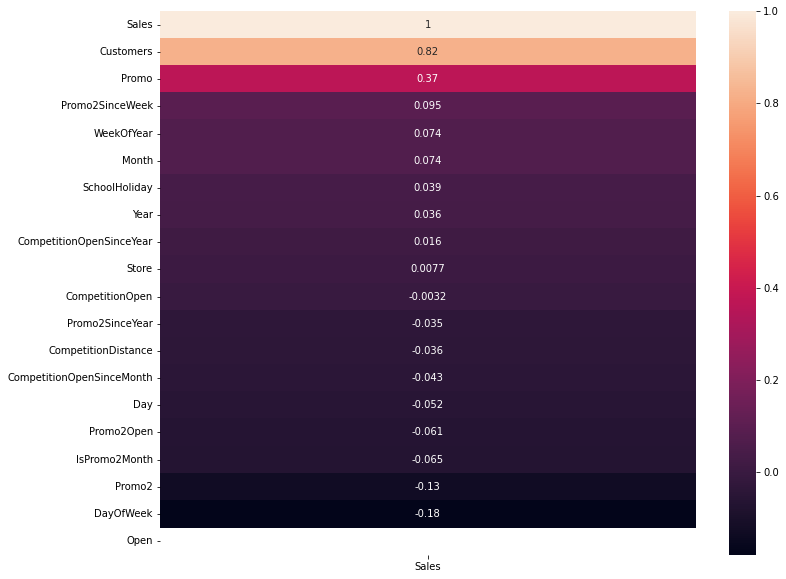

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix[['Sales']].sort_values(by='Sales',ascending=False), annot=True)

In [85]:
import plotly.express as px

In [86]:
px.scatter(merged_df, x='Sales', y='Customers')

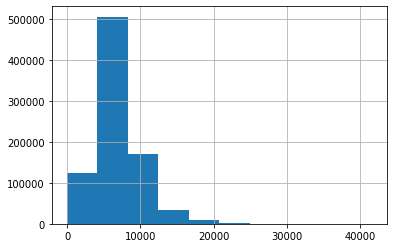

In [87]:
merged_df.Sales.hist()

In [88]:
merged_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  Month  Day  \
0              NaN              NaN              NaN  2015      7   31   
1             13.0           2010.0  Jan,Apr,Jul,Oct  2015      7   31   
2             14.0           2011.0  Jan,Apr,Jul,Oct  2015      7   31   
3              NaN              NaN              NaN  2015      7   31   
4              NaN              NaN              NaN  2015      7   31   

   WeekOfYear  CompetitionOpen  Promo2Open  IsPromo2Month  
0          31             82.0    0.000000              0  
1          31             92.0   64.131148              1  
2          31            103.0   51.901639              1  
3          31             70.0    0.000000              0  
4          31              3.0    0.000000              0

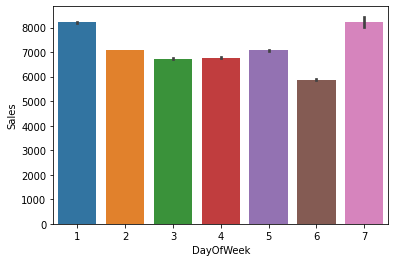

In [89]:
sns.barplot(data=merged_df, x='DayOfWeek', y='Sales')

## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [90]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        842206 non-null  float64


### Date

First, let's convert `Date` to a `datetime` column and extract different parts of the date.

In [91]:
def split_date(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df.Date.dt.year
  df['Month'] = df.Date.dt.month
  df['Day'] = df.Date.dt.day
  df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [92]:
split_date(merged_df)
split_date(merged_test_df)

In [93]:
merged_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  Month  Day  \
0              NaN              NaN              NaN  2015      7   31   
1             13.0           2010.0  Jan,Apr,Jul,Oct  2015      7   31   
2             14.0           2011.0  Jan,Apr,Jul,Oct  2015      7   31   
3              NaN              NaN              NaN  2015      7   31   
4              NaN              NaN              NaN  2015      7   31   

   WeekOfYear  CompetitionOpen  Promo2Open  IsPromo2Month  
0          31             82.0    0.000000              0  
1          31             92.0   64.131148              1  
2          31            103.0   51.901639              1  
3          31             70.0    0.000000              0  
4          31              3.0    0.000000              0

### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [94]:
merged_df[merged_df.Open==0].Sales.value_counts()

Series([], Name: Sales, dtype: int64)

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [95]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [96]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [97]:
comp_months(merged_df)
comp_months(merged_test_df)

In [98]:
merged_df.CompetitionOpen

0           82.0
1           92.0
2          103.0
3           70.0
4            3.0
           ...  
1016776     76.0
1016827    159.0
1016863      0.0
1017042      0.0
1017190    130.0
Name: CompetitionOpen, Length: 844392, dtype: float64

In [99]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

Date  CompetitionDistance  CompetitionOpenSinceYear  \
749895 2013-08-28               1460.0                    2015.0   
790575 2013-07-23               7980.0                    2005.0   
819    2015-07-31               1650.0                       NaN   
807467 2013-07-08               3460.0                    2013.0   
454166 2014-05-20               2910.0                       NaN   
176400 2015-02-23               3840.0                    2008.0   
820111 2013-06-26                420.0                    2012.0   
150103 2015-03-19                460.0                    2012.0   
92765  2015-05-09              13530.0                    2013.0   
639095 2013-12-06                620.0                    2014.0   
840231 2013-06-08              18660.0                    2002.0   
631950 2013-12-12               4030.0                       NaN   
739625 2013-09-06              10570.0                    2013.0   
526572 2014-03-17                670.0                       NaN   
603173 2014-01-07               1370.0                    2011.0   
405147 2014-07-04               3910.0                    2006.0   
118726 2015-04-16                600.0                    2002.0   
387111 2014-07-23                780.0                       NaN   
291061 2014-11-03                990.0                    2010.0   
179926 2015-02-20               4460.0                       NaN   

        CompetitionOpenSinceMonth  CompetitionOpen  
749895                        4.0              0.0  
790575                        6.0             97.0  
819                           NaN              0.0  
807467                       10.0              0.0  
454166                        NaN              0.0  
176400                       10.0             76.0  
820111                       12.0              6.0  
150103                       11.0             28.0  
92765                         9.0             20.0  
639095                       10.0              0.0  
840231                        9.0            129.0  
631950                        NaN              0.0  
739625                        7.0              2.0  
526572                        NaN              0.0  
603173                       12.0             25.0  
405147                       11.0             92.0  
118726                        5.0            155.0  
387111                        NaN              0.0  
291061                        2.0             57.0  
179926                        NaN              0.0

### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [100]:
merged_df.PromoInterval.sample(10)

249181                NaN
7671                  NaN
365092    Jan,Apr,Jul,Oct
345391                NaN
137862                NaN
112993                NaN
825789                NaN
398644    Jan,Apr,Jul,Oct
867778    Jan,Apr,Jul,Oct
459001    Feb,May,Aug,Nov
Name: PromoInterval, dtype: object

In [101]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0


In [102]:
def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [103]:
%%timeit
promo_cols(merged_df)
promo_cols(merged_test_df)

17.6 s ± 314 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


view created columns

In [104]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].head(20)

Date  Promo2  Promo2SinceYear  Promo2SinceWeek     PromoInterval  \
0  2015-07-31       0              NaN              NaN               NaN   
1  2015-07-31       1           2010.0             13.0   Jan,Apr,Jul,Oct   
2  2015-07-31       1           2011.0             14.0   Jan,Apr,Jul,Oct   
3  2015-07-31       0              NaN              NaN               NaN   
4  2015-07-31       0              NaN              NaN               NaN   
5  2015-07-31       0              NaN              NaN               NaN   
6  2015-07-31       0              NaN              NaN               NaN   
7  2015-07-31       0              NaN              NaN               NaN   
8  2015-07-31       0              NaN              NaN               NaN   
9  2015-07-31       0              NaN              NaN               NaN   
10 2015-07-31       1           2012.0              1.0   Jan,Apr,Jul,Oct   
11 2015-07-31       1           2010.0             13.0   Jan,Apr,Jul,Oct   
12 2015-07-31       1           2009.0             45.0   Feb,May,Aug,Nov   
13 2015-07-31       1           2011.0             40.0   Jan,Apr,Jul,Oct   
14 2015-07-31       1           2011.0             14.0   Jan,Apr,Jul,Oct   
15 2015-07-31       0              NaN              NaN               NaN   
16 2015-07-31       1           2010.0             26.0   Jan,Apr,Jul,Oct   
17 2015-07-31       1           2012.0             14.0   Jan,Apr,Jul,Oct   
18 2015-07-31       1           2011.0             22.0  Mar,Jun,Sept,Dec   
19 2015-07-31       1           2014.0             40.0   Jan,Apr,Jul,Oct   

    Promo2Open  IsPromo2Month  
0     0.000000              0  
1    64.131148              1  
2    51.901639              1  
3     0.000000              0  
4     0.000000              0  
5     0.000000              0  
6     0.000000              0  
7     0.000000              0  
8     0.000000              0  
9     0.000000              0  
10   42.885246              1  
11   64.131148              1  
12   68.786885              0  
13   45.934426              1  
14   51.901639              1  
15    0.000000              0  
16   61.147541              1  
17   39.901639              1  
18   50.065574              0  
19    9.934426              1

### Input and Target Columns

Let's select the columns that we'll use for training.

In [105]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [106]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [107]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [108]:
test_inputs = merged_test_df[input_cols].copy()

separate numerical and catergorical columns

In [109]:
import numpy as np
numeric_cols = inputs.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('DayOfWeek')
numeric_cols

['Store',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'CompetitionOpen',
 'Day',
 'Month',
 'Year',
 'WeekOfYear',
 'Promo2',
 'Promo2Open',
 'IsPromo2Month']

In [110]:
categorical_cols = inputs.select_dtypes(include='object').columns.tolist()
categorical_cols.append('DayOfWeek')
categorical_cols

['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']

categorical_cols

In [111]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
dtype: int64

In [112]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [113]:
max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [124]:
inputs.CompetitionDistance.fillna(max_distance*2, inplace=True)
test_inputs.CompetitionDistance.fillna(max_distance*2, inplace=True)

In [125]:
inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
dtype: int64

In [126]:
test_inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
dtype: int64

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [127]:
from sklearn.preprocessing import MinMaxScaler

In [128]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [129]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [130]:
from sklearn.preprocessing import OneHotEncoder

In [131]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore',drop='first').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [132]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [133]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Gradient Boosting Machine

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

> **EXERCISE**: Can you describe in your own words how a gradient boosting machine is different from a random forest?


For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)


### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [134]:
from xgboost import XGBRegressor

In [135]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [136]:
%%time
model.fit(X, targets)

CPU times: user 28.8 s, sys: 16.1 ms, total: 28.8 s
Wall time: 16.7 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [137]:
preds = model.predict(X)

In [138]:
preds

array([8445.5205, 8139.329 , 8642.053 , ..., 7332.371 , 7304.349 ,
       8839.684 ], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [140]:
from sklearn.metrics import mean_squared_error
mean_squared_error(preds, targets, squared=False)

2400.3814324741925

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [142]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,30

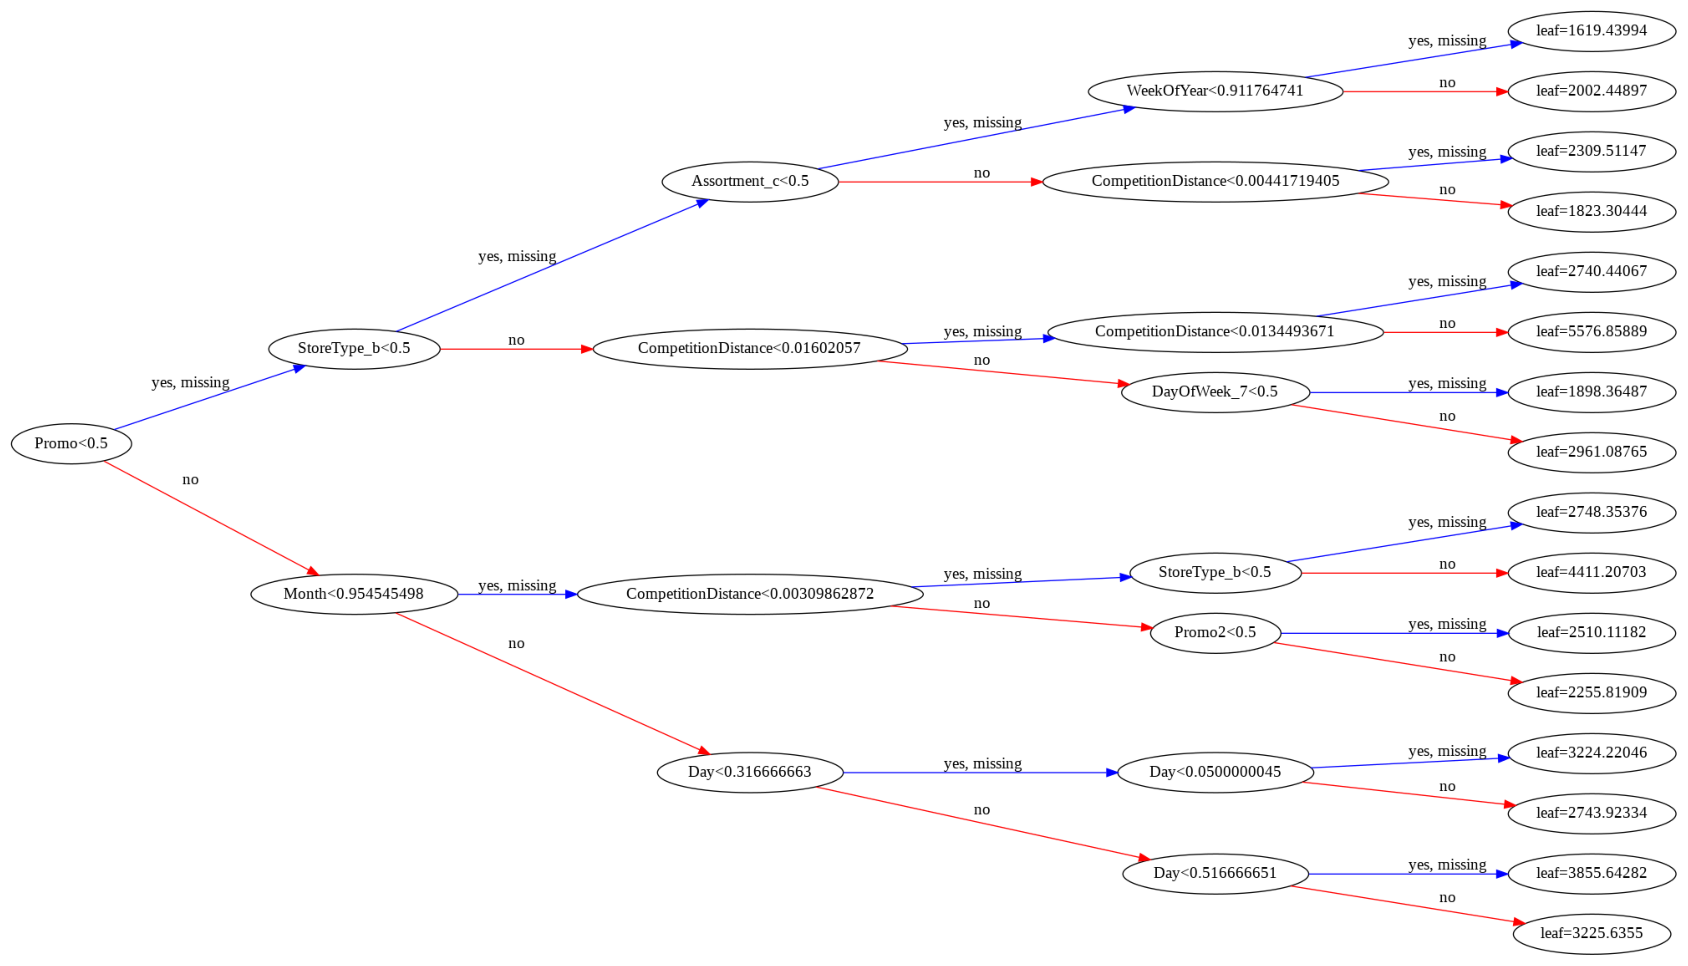

In [145]:
plot_tree(model, rankdir='LR')

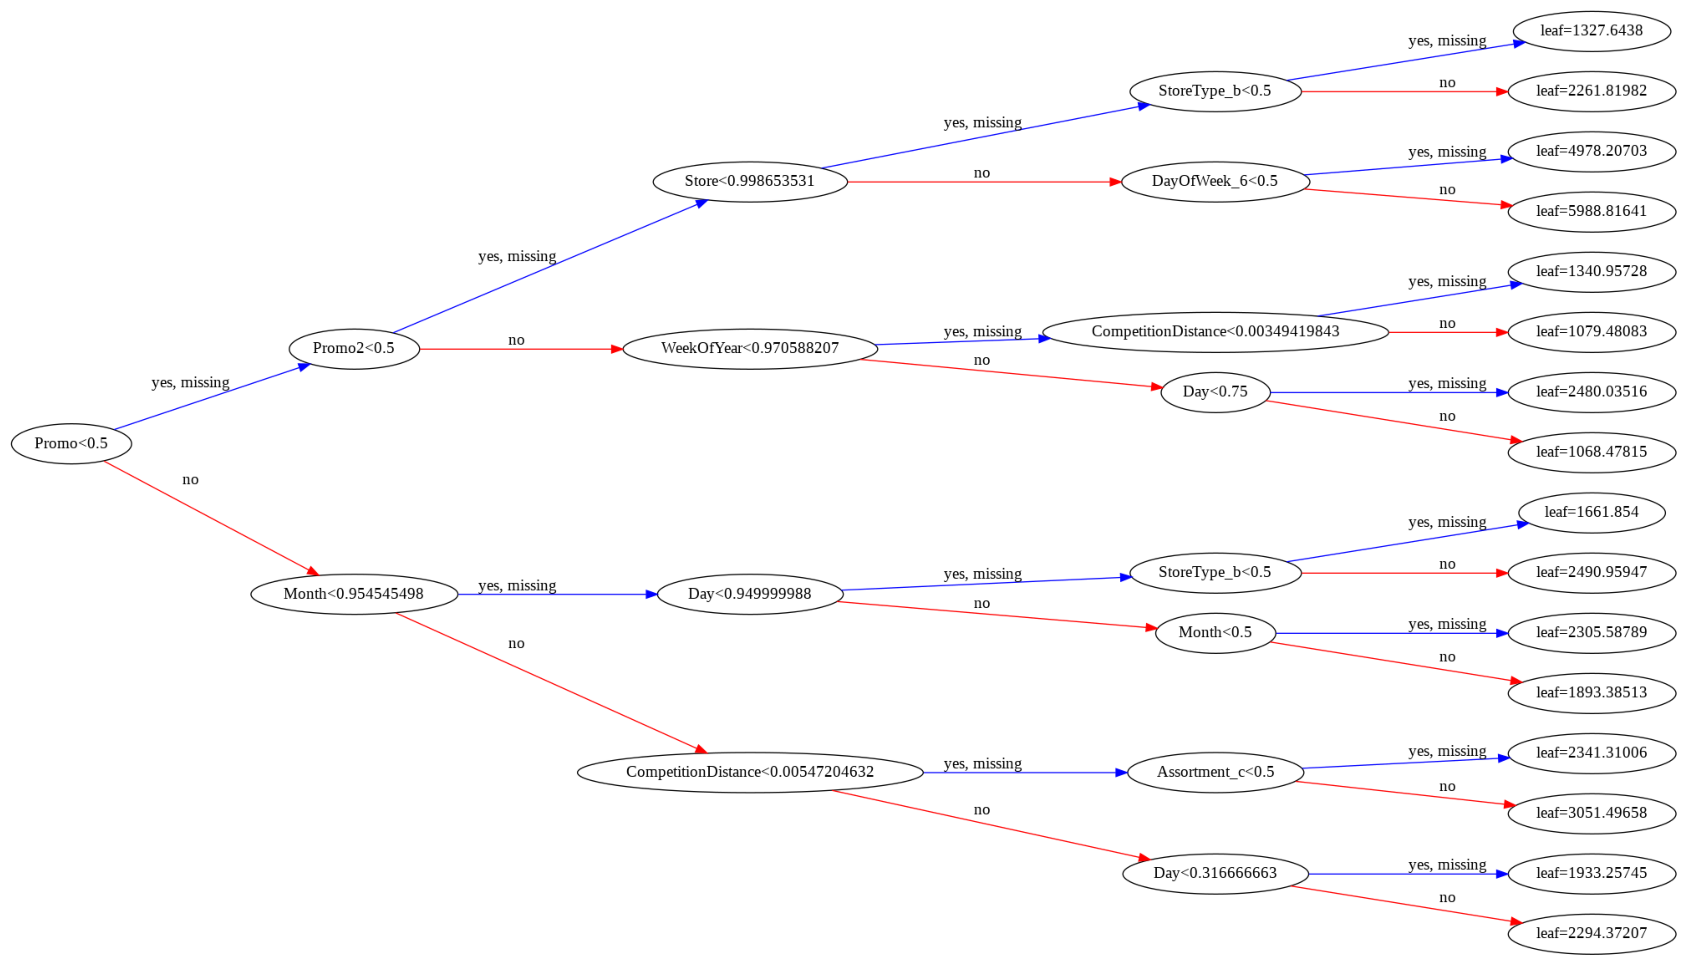

In [146]:
plot_tree(model, rankdir='LR', num_trees=1)

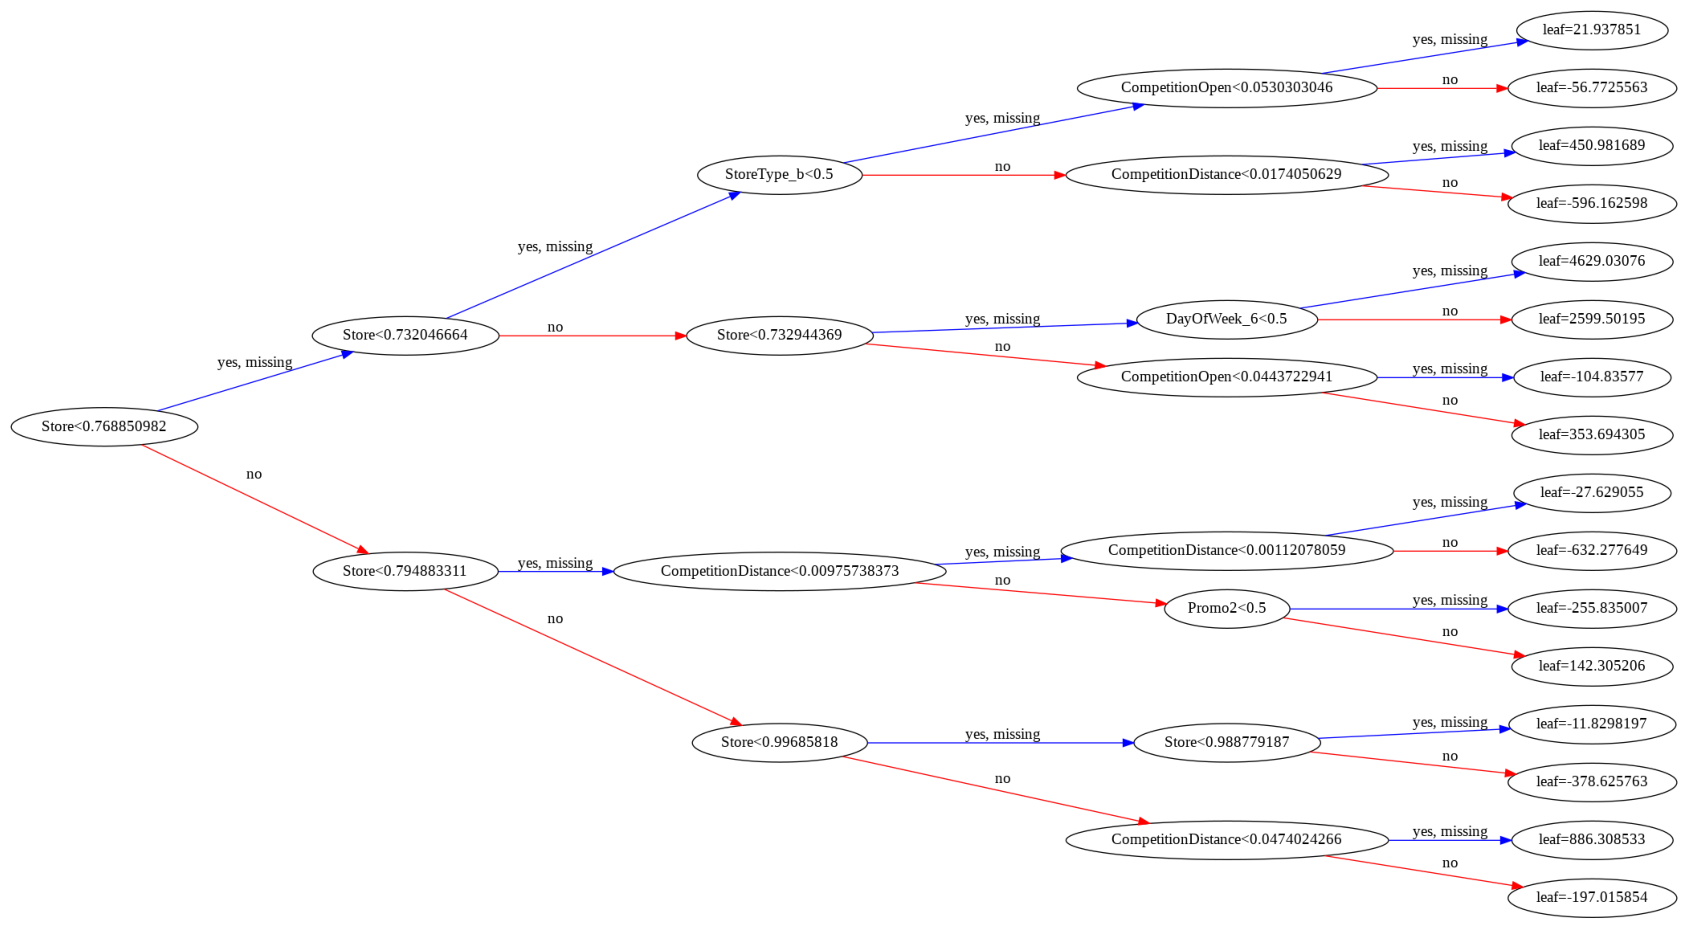

In [147]:
plot_tree(model, rankdir='LR', num_trees=19)

In [148]:
trees = model.get_booster().get_dump()
len(trees)

20

In [150]:
print(trees[0])

0:[Promo<0.5] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_c<0.5] yes=7,no=8,missing=7
			7:[WeekOfYear<0.911764741] yes=15,no=16,missing=15
				15:leaf=1619.43994
				16:leaf=2002.44897
			8:[CompetitionDistance<0.00441719405] yes=17,no=18,missing=17
				17:leaf=2309.51147
				18:leaf=1823.30444
		4:[CompetitionDistance<0.01602057] yes=9,no=10,missing=9
			9:[CompetitionDistance<0.0134493671] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[Month<0.954545498] yes=5,no=6,missing=5
		5:[CompetitionDistance<0.00309862872] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2748.35376
				24:leaf=4411.20703
			12:[Promo2<0.5] yes=25,no=26,missing=25
				25:leaf=2510.11182
				26:leaf=2255.81909
		6:[Day<0.316666663] yes=13,no=14,missing=13
			13:[Day<0.0500000045] yes=27,no=28,missing=27
				27:leaf=3224.22

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [157]:
importance_df = pd.DataFrame({
    'feature':X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [158]:
importance_df.head(10)

feature  importance
1                 Promo    0.301254
15          StoreType_b    0.089900
9                Promo2    0.064296
0                 Store    0.051884
19         Assortment_c    0.050588
6                 Month    0.047697
3   CompetitionDistance    0.047423
22          DayOfWeek_4    0.042593
23          DayOfWeek_5    0.040058
8            WeekOfYear    0.034235

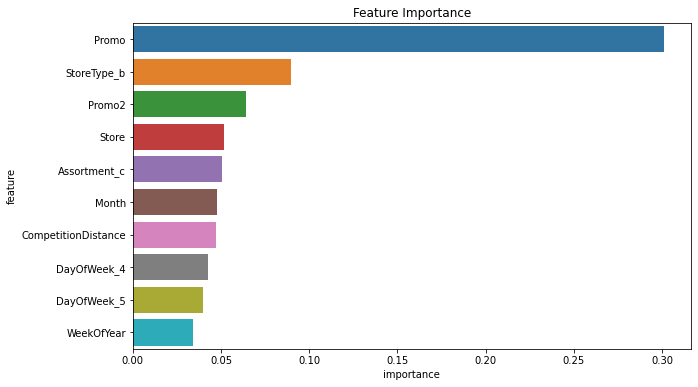

In [159]:
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x= 'importance', y='feature')

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

In [160]:
from sklearn.model_selection import KFold

Let's define a helper function `train_and_evaluate` which trains a model on the given parameters and returns the trained model, training error and validation error.

In [166]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = mean_squared_error(model.predict(X_train), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(X_val), val_targets, squared=False)
    return model, train_rmse, val_rmse

In [167]:
kfold = KFold(n_splits=5)

In [168]:
models = []
for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train,
                                                    train_targets,
                                                    X_val,
                                                    val_targets,
                                                    max_depth=4,
                                                    n_estimators = 20)
    models.append(model)
    print(f'Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}')

Train RMSE: 2388.2683290615123, Validation RMSE: 2450.8433368378282
Train RMSE: 2378.4150766084367, Validation RMSE: 2406.106494000387
Train RMSE: 2441.874582380741, Validation RMSE: 2417.9498448663635
Train RMSE: 2368.2392557285416, Validation RMSE: 2481.6871202293746
Train RMSE: 2392.6661477033135, Validation RMSE: 2450.442728946174


Let's also define a function to average predictions from the 5 different models.

In [169]:
import numpy as np
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [170]:
preds = predict_avg(models, X)

In [171]:
preds

array([8107.4688, 7593.2646, 8517.575 , ..., 7898.85  , 7279.712 ,
       9519.012 ], dtype=float32)

We can now use `predict_avg` to make predictions for the test set.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

Here's a helper function to test hyperparameters with K-fold cross validation.

In [ ]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [184]:
from pandas.core.common import random_state
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = mean_squared_error(model.predict(X_train), train_targets, squared=False)
    val_rmse  = mean_squared_error(model.predict(X_val), val_targets, squared=False)
    print(f'Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}')
    return train_rmse, val_rmse

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.

In [177]:
test_params(n_estimators=10)

Train RMSE: 2384.448795996972, Validation RMSE: 2399.954286026597


In [178]:
test_params(n_estimators=30)

Train RMSE: 1912.9159357858844, Validation RMSE: 1914.7719510701725


In [179]:
test_params(n_estimators=100)

Train RMSE: 1201.937991106125, Validation RMSE: 1204.6985986255766


In [180]:
test_params(n_estimators=240)

Train RMSE: 915.3563139710061, Validation RMSE: 923.5654537497145


> **EXERCISE**: Experiment with different values of `n_estimators`, plot a graph of the training and validation error and determine the best value for `n_estimators`.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

In [185]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], []
    for value in param_values:
        params = {param_name:value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])


In [ ]:
test_param_and_plot('n_estimators', list(range(1, 250, 50)))

Train RMSE: 5646.641320775071, Validation RMSE: 5673.18018875947
Train RMSE: 2136.6915462643224, Validation RMSE: 2146.9412355153613
Train RMSE: 1741.3382967125995, Validation RMSE: 1741.9020920893618
Train RMSE: 1470.081251548633, Validation RMSE: 1469.93474764136
Train RMSE: 1313.5954726256766, Validation RMSE: 1314.7488974647881
Train RMSE: 1197.8475832234478, Validation RMSE: 1200.641442009713
Train RMSE: 1113.252622573308, Validation RMSE: 1115.675761549428
Train RMSE: 1063.0559738859154, Validation RMSE: 1066.238730857623
Train RMSE: 1016.7817369450179, Validation RMSE: 1020.7422548087424
Train RMSE: 985.4501692449462, Validation RMSE: 990.4993288904169
Train RMSE: 958.6088874075049, Validation RMSE: 964.5077029369594
Train RMSE: 935.1869051130525, Validation RMSE: 941.8471626246542
Train RMSE: 914.4651867945815, Validation RMSE: 922.6493242024981
Train RMSE: 894.682499858766, Validation RMSE: 904.3649664855611
Train RMSE: 879.0679682171839, Validation RMSE: 890.2478042714619
Tra

#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

> **EXERCISE**: Experiment with different values of `max_depth`, plot a graph of the training and validation error and determine the optimal.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

In [ ]:
test_param_and_plot('max_depth', list(range(1, 100, 10)))

#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)

In [ ]:
test_params(n_estimators=50, learning_rate=0.1)

In [ ]:
test_params(n_estimators=50, learning_rate=0.99)

> **EXERCISE**: Experiment with different values of `learning_rate`, plot a graph of the training and validation error and determine the optimal.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

In [ ]:
test_param_and_plot('learning_rate', [0.001,0.005,0.01, 0.05, 0.1, 1])

#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [ ]:
test_params(booster='gblinear')

> **EXERCISE**: Exeperiment with other hyperparameters like `gamma`, `min_child_weight`, `max_delta_step`, `subsample`, `colsample_bytree` etc. and find their optimal values. Learn more about them here: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

> **EXERCISE**: Train a model with your best hyperparmeters and evaluate its peformance using 5-fold cross validation.